<a href="https://colab.research.google.com/github/dmamur/elementsem/blob/main/elembert_matsimilarity_matbench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical


In [2]:
!git clone https://github.com/dmamur/elementsem.git 

fatal: destination path 'elementsem' already exists and is not an empty directory.


In [3]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 128
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    NUM_HEAD = 4 # used in bert model
    FF_DIM = 128 # used in bert model
    NUM_LAYERS = 4
    MNAME = 'elembert_'
    MVER = 'V1'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=123
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
ds = 'matbench'
mname=config.PATH+config.MNAME+ds+config.MVER

# Load vocabulary and types 

In [5]:
df = pd.read_csv(config.DSPATH+ds+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


vocabSize:  565


In [6]:
len(types)

21222

# Convert types to integers

In [7]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',maxlen=config.MAX_LEN)

z = load_model(config.PREPATH+'/elembert_'+config.MVER+'_E_128_H_4_L_4_bert.h5',compile=False)
z.trainable = False

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

#plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

epochs=config.BATCH_SIZE
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 types (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 element_embdgs (Embedding)     (None, 128, 128)     72320       ['types[0][0]']                  
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 128, 128)    0           ['element_embdgs[0][0]']         
 da)                                                                                              
                                                                                                  
 encoder_0/multiheadattention (  (None, 128, 128)    66048       ['tf.__operators__.add[0][0]'

# Get compound embeddings

In [8]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['formula'] = df['formula'] 
dbresults['ids'] = df['ids']  
dbresults['types'] = types

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

166/166 [==============================] - 94s 560ms/step


In [9]:
formula = df['formula'].to_list()
with open(config.PATH+ds+'_embeddings'+config.MVER+'.txt', 'w') as f:
    f.write(str(len(dbresults['pred_emb']))+' '+str(config.MAX_LEN)+'\n')
    for i,j in enumerate(dbresults['pred_emb']):
        f.write(formula[i].replace('1','').replace('0','')+' ')
        [f.write("{:.6f}".format(i0)+' ') for i0 in j]
        f.write('\n')


# Postprocessing: get similar materials by gensim request

In [10]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
def tsnescatterplot(model, word, list_names,axs):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 128), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('royalblue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    #reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=213, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    #fig, axs = plt.subplots()
    #fig.set_size_inches(5, 5)
    
    # Basic plot
    p1 = sns.regplot(ax=axs,
                     data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].replace('1','').translate(sub),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    axs.set_xlabel('$tSNE_1$')
    axs.set_ylabel('$tSNE_2$',labelpad=1)
    axs.set_xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    axs.set_ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    #axs.set_title('t-SNE visualization for {}'.format(word.replace('1','').translate(sub)))
    


In [12]:
model = KeyedVectors.load_word2vec_format(config.PATH+ds+'_embeddings'+config.MVER+'.txt')

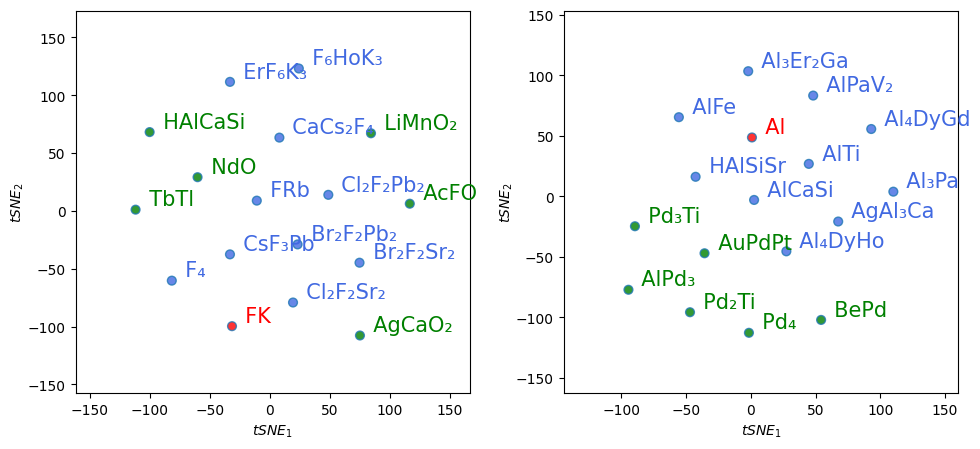

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4.6))
tsnescatterplot(model, 'FK', [i[0] for i in model.most_similar(positive=['FLi'],topn=6)],axes[0]) #Be2-hex, Be4-tetra,Be-cubic 
tsnescatterplot(model, 'Al', [i[0] for i in model.most_similar(positive=['Pd'],topn=6)],axes[1])
fig.tight_layout()